# Exercise
**file name**: `clustering_anomaly_detection.py` or `clustering_anomaly_detection.ipynb`

# Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


#used for DBclustering and scaling
from sklearn.cluster import DBSCAN
#using MinMax b'c Standard can have LESSTHAN 0, and Epsolon is 0-1 only
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import wrangle as w

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


In [5]:
# cluster on subset of features
grocery_milk_fresh = df[["Grocery", "Milk","Fresh"]]

In [6]:
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


In [7]:
grocery_milk_fresh.columns

Index(['Grocery', 'Milk', 'Fresh'], dtype='object')

In [8]:
scaler = MinMaxScaler().fit(grocery_milk_fresh)
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)

- Experiment with altering the epsilon values (the eps argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?

In [9]:
dbsc = DBSCAN(eps = .50, min_samples = 20).fit(grocery_milk_fresh)

In [10]:
gmf_columns = ['Grocery', 'Milk', 'Fresh']

In [11]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)

scaled_columns = ["Scaled_" + column for column in gmf_columns]

In [12]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [13]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
df['labels'] = labels
df.labels.value_counts()

 0    439
-1      1
Name: labels, dtype: int64

In [15]:
df[df.labels==-1].head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
85,2,3,16117,46197,92780,1026,40827,2944,1.0,0.62827,0.143685,-1


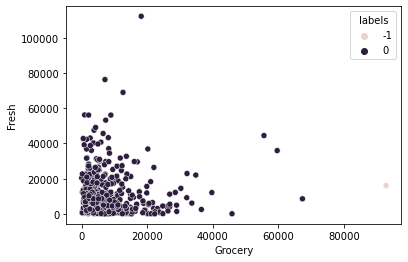

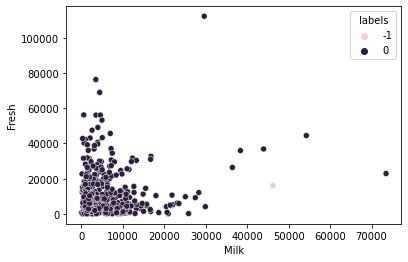

In [16]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

In [51]:

%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

𝛆 = 1.0


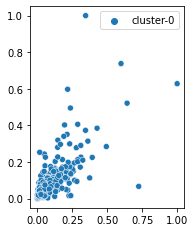

𝛆 = 0.5


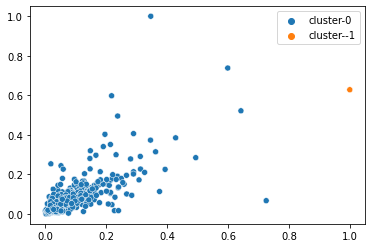

𝛆 = 0.3333333333333333


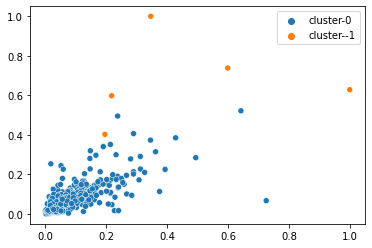

𝛆 = 0.25


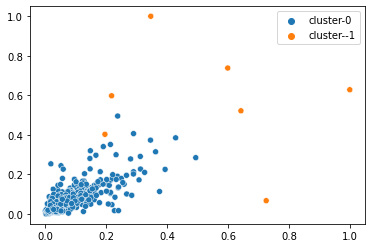

𝛆 = 0.2


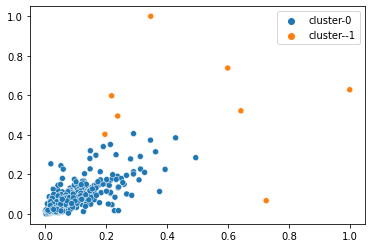

𝛆 = 0.16666666666666666


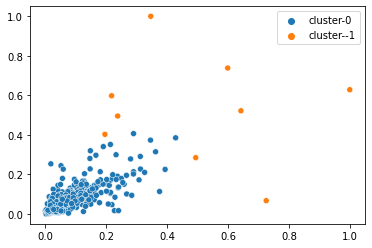

𝛆 = 0.14285714285714285


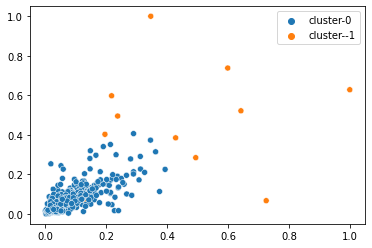

𝛆 = 0.125


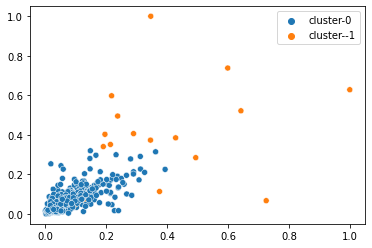

𝛆 = 0.1111111111111111


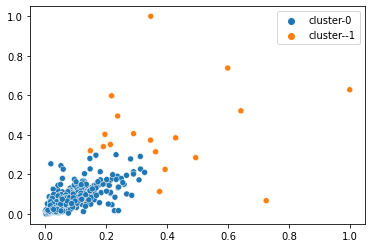

𝛆 = 0.1


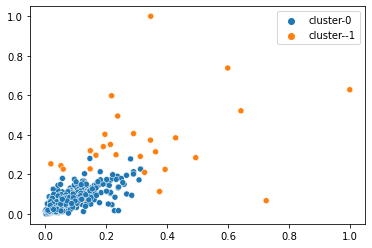

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=25).fit(grocery_milk_fresh)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'𝛆 = {eps}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

min_sample = 0


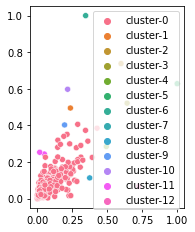

min_sample = 20


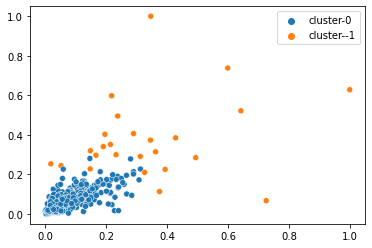

min_sample = 40


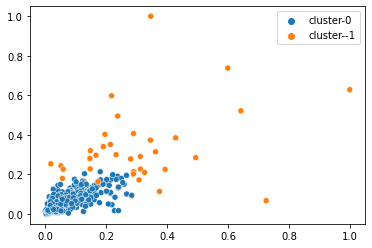

min_sample = 60


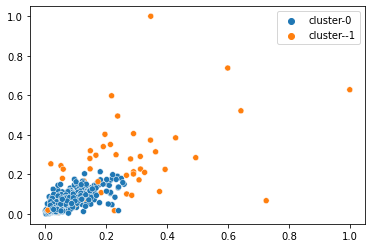

In [18]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(4):
    minsample = 20*x
    db = DBSCAN(eps=0.1, min_samples=minsample).fit(grocery_milk_fresh)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'min_sample = {minsample}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

***
## Clustering - DBSCAN
Use DBSCAN to detect anomalies in other products from the customers dataset.

In [19]:
# cluster on subset of features
grocery_frozen_deli = df[["Grocery", "Frozen","Delicassen"]]

In [20]:
grocery_frozen_deli.head(2)

,Grocery,Frozen,Delicassen
0,7561,214,1338
1,9568,1762,1776


In [21]:
grocery_frozen_deli.columns

Index(['Grocery', 'Frozen', 'Delicassen'], dtype='object')

In [22]:
gfd_columns = ['Grocery', 'Frozen', 'Delicassen']

In [23]:
# scale
scaler = MinMaxScaler().fit(grocery_frozen_deli)
grocery_frozen_deli = scaler.transform(grocery_frozen_deli)

In [24]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(grocery_frozen_deli)

In [25]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)

scaled_columns = ["Scaled_" + column for column in gfd_columns]

In [26]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_frozen_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

𝛆 = 1.0


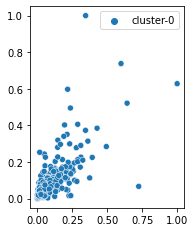

𝛆 = 0.5


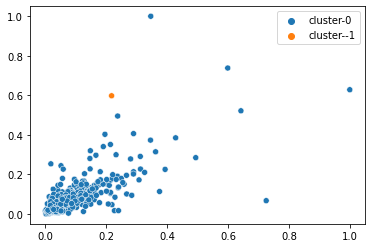

𝛆 = 0.3333333333333333


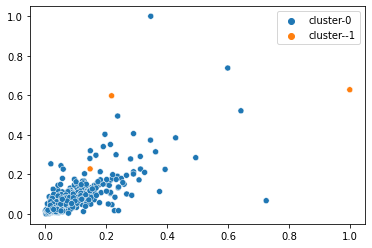

𝛆 = 0.25


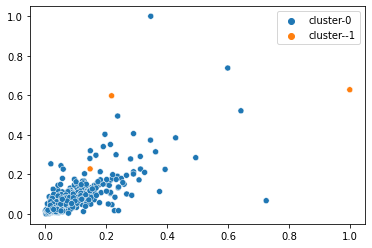

𝛆 = 0.2


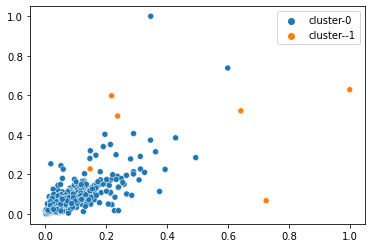

𝛆 = 0.16666666666666666


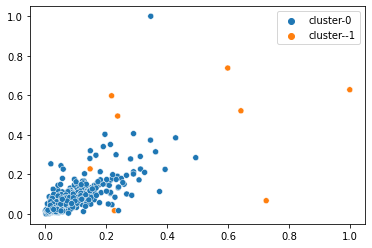

𝛆 = 0.14285714285714285


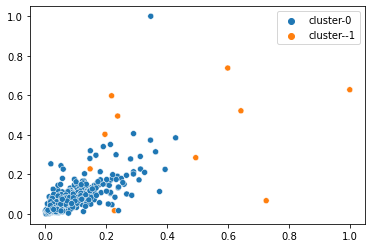

𝛆 = 0.125


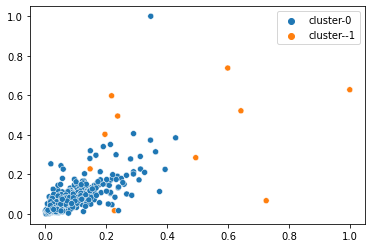

𝛆 = 0.1111111111111111


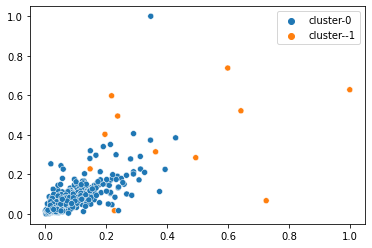

𝛆 = 0.1


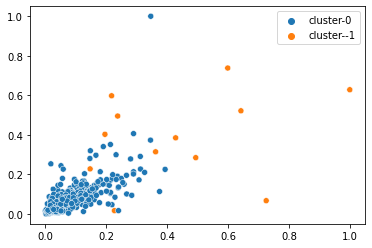

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=20).fit(grocery_frozen_deli)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'𝛆 = {eps}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

In [63]:
%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Delicassen, df.Frozen, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Delicassen')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

___
# Use DBSCAN to detect anomalies in: 
- number of bedrooms and 
- finished square feet of property 

for the filtered dataset you used in the `clustering project` (single unit properties with a logerror).

In [2]:
zlo = w.zillow17()

In [3]:
zlo.shape

(77574, 68)

In [4]:
zlo.head(2)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [5]:
zlo = w.clean_zillow(zlo)

In [6]:
zlo.shape

(45788, 17)

In [7]:
zlo.head(2)

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles
parcelid,,,,,,,,,,,,,,,,,
12177905,3.0,4,8,2376.0,6037,34245180.0,-118240722.0,13038.0,1970,108918.0,145143.0,36225.0,1777.51,-0.10341,Los_Angeles,51,q1
10887214,3.0,3,8,1312.0,6037,34185120.0,-118414640.0,278581.0,1964,73681.0,119407.0,45726.0,1533.89,0.00694,Los_Angeles,57,q3


In [6]:
# cluster on subset of features
bdrmsqft = zlo[["bedrooms", "sqft"]]

In [7]:
bdrmsqft.head(2)

,bedrooms,sqft
parcelid,,
12177905,4,2376.0
10887214,3,1312.0


In [17]:
#create a list of column names from clustered subset of features: nu_df
columns = bdrmsqft.columns.to_list()

In [18]:
#scale and transform the DF
scaler = MinMaxScaler().fit(bdrmsqft)
bdrmsqft = scaler.transform(bdrmsqft)

In [19]:
#Construct a DBSCAN object 
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(bdrmsqft)

In [13]:
#add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in columns]

NameError: name 'columns' is not defined

In [14]:
scaled_columns

NameError: name 'scaled_columns' is not defined

In [21]:
# Save a copy of the original dataframe
original_zlo = zlo.copy()

In [22]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(bdrmsqft, columns=scaled_columns)

In [23]:
# Merge the scaled and non-scaled values into one dataframe
zlo = zlo.merge(scaled_df, on=zlo.index)
zlo = zlo.drop(columns=['key_0'])

In [11]:
scaled_df.head(2)

NameError: name 'scaled_df' is not defined

In [24]:
#extract cluster labels and outliers 
labels = dbsc.labels_
zlo['labels'] = labels

ValueError: Length of values (45788) does not match length of index (46020)

In [10]:
def densitybasedcluster(df, nu_df):
    """
    
    """
    #create a list of column names from clustered subset of features: nu_df
    columns = nu_df.columns.to_list()
    
    #scale and transform the DF
    scaler = MinMaxScaler().fit(nu_df)
    nu_df = scaler.transform(nu_df)
    
    #Construct a DBSCAN object 
    dbsc = DBSCAN(eps = .10, min_samples = 20).fit(nu_df)
    
    #add the scaled value columns back onto the dataframe
    scaled_columns = ["Scaled_" + column for column in columns]
    
    # Save a copy of the original dataframe
    original_df = df.copy()
    
    # Create a dataframe containing the scaled values
    scaled_df = pd.DataFrame(nu_df, columns=scaled_columns)
    
    # Merge the scaled and non-scaled values into one dataframe
    df = df.merge(scaled_df, on=df.index)
    df = df.drop(columns=['key_0'])
    
    #extract cluster labels and outliers 
    labels = dbsc.labels_
    df['labels'] = labels

In [11]:
densitybasedcluster(zlo, bdrmsqft)

ValueError: Length of values (45788) does not match length of index (46020)

In [15]:
bdrmsqft.shape, zlo.shape

((45788, 2), (45788, 17))

In [16]:
len(bdrmsqft.index), len(zlo.index)

(45788, 45788)